# Multi step model (encoder-decoder with teacher forcing)

In this notebook, we will demonstrate how to implement a RNN model to predict multiple time steps into the future using an encoder decoder. The decoder part of the model uses teacher forcing, a method by which the output of one time step is fed to the input of the next time step.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
%matplotlib inline

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)

In [2]:
%run -i load_data.py
%run -i mape.py
%run -i TimeSeriesTensor.py
%run -i create_evaluation_df.py

In [3]:
if not os.path.exists(os.path.join('data', 'energy.csv')):
    %run extract_data.py
energy = load_data()
energy.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


In [4]:
valid_start_dt = '2014-09-01 00:00:00'
test_start_dt = '2014-11-01 00:00:00'

T = 6
HORIZON = 3

In [5]:
train = energy.copy()[energy.index < valid_start_dt][['load']]

In [6]:
from sklearn.preprocessing import MinMaxScaler

y_scaler = MinMaxScaler()
y_scaler.fit(train[['load']])

X_scaler = MinMaxScaler()
train[['load']] = X_scaler.fit_transform(train)

In [7]:
tensor_structure = {'encoder_input':(range(-T+1, 1), ['load']), 'decoder_input':(range(0, HORIZON), ['load'])}
train_inputs = TimeSeriesTensor(train, 'load', HORIZON, tensor_structure)
train_inputs.shifted_df.head()

tensor              target           decoder_input           encoder_input  \
feature                  y                    load                    load   
time step              t+1  t+2  t+3             t  t+1  t+2           t-5   
2012-01-01 05:00:00   0.18 0.23 0.29          0.15 0.18 0.23          0.22   
2012-01-01 06:00:00   0.23 0.29 0.35          0.18 0.23 0.29          0.18   
2012-01-01 07:00:00   0.29 0.35 0.37          0.23 0.29 0.35          0.14   
2012-01-01 08:00:00   0.35 0.37 0.37          0.29 0.35 0.37          0.13   
2012-01-01 09:00:00   0.37 0.37 0.37          0.35 0.37 0.37          0.13   

tensor                                        
feature                                       
time step            t-4  t-3  t-2  t-1    t  
2012-01-01 05:00:00 0.18 0.14 0.13 0.13 0.15  
2012-01-01 06:00:00 0.14 0.13 0.13 0.15 0.18  
2012-01-01 07:00:00 0.13 0.13 0.15 0.18 0.23  
2012-01-01 08:00:00 0.13 0.15 0.18 0.23 0.29  
2012-01-01 09:00:00 0.15 0.18 0.23 0.29 0.35

In [8]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = energy.copy()[(energy.index >=look_back_dt) & (energy.index < test_start_dt)][['load']]
valid[['load']] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, 'load', HORIZON, tensor_structure)

## Implement training model

In [9]:
from keras.models import Model, Sequential
from keras.layers import GRU, Dense, RepeatVector, TimeDistributed, Flatten, Input
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [10]:
BATCH_SIZE = 32
EPOCHS = 100
LATENT_DIM = 5

In [11]:
# define training encoder
encoder_inputs = Input(shape=(None, 1))
encoder = GRU(LATENT_DIM, return_state=True)
encoder_outputs, state_h = encoder(encoder_inputs)
encoder_states = [state_h]

# define training decoder
decoder_inputs = Input(shape=(None, 1))
decoder_GRU = GRU(LATENT_DIM, return_state=True, return_sequences=True)
decoder_outputs, _ = decoder_GRU(decoder_inputs, initial_state=encoder_states)
decoder_dense = TimeDistributed(Dense(1))
decoder_outputs = decoder_dense(decoder_outputs)
#flatten = Flatten()
#decoder_outputs = flatten(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [12]:
model.compile(optimizer='RMSprop', loss='mse')

In [13]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [14]:
train_target = train_inputs['target'].reshape(train_inputs['target'].shape[0], train_inputs['target'].shape[1], 1)
valid_target = valid_inputs['target'].reshape(valid_inputs['target'].shape[0], valid_inputs['target'].shape[1], 1)

In [15]:
model.fit([train_inputs['encoder_input'], train_inputs['decoder_input']],
          train_target,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=([valid_inputs['encoder_input'], valid_inputs['decoder_input']], valid_target),
          callbacks=[earlystop],
          verbose=1)

Train on 23368 samples, validate on 1461 samples
Epoch 1/100
23368/23368 [==============================] - 4s 193us/step - loss: 0.0295 - val_loss: 0.0024
Epoch 2/100
23368/23368 [==============================] - 4s 179us/step - loss: 0.0018 - val_loss: 0.0012
Epoch 3/100
23368/23368 [==============================] - 4s 166us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 4/100
23368/23368 [==============================] - 4s 181us/step - loss: 8.2803e-04 - val_loss: 6.9578e-04
Epoch 5/100
23368/23368 [==============================] - 4s 173us/step - loss: 7.2612e-04 - val_loss: 7.7220e-04
Epoch 6/100
23368/23368 [==============================] - 4s 179us/step - loss: 6.6919e-04 - val_loss: 7.2845e-04
Epoch 7/100
23368/23368 [==============================] - 4s 179us/step - loss: 6.3502e-04 - val_loss: 5.6978e-04
Epoch 8/100
23368/23368 [==============================] - 4s 160us/step - loss: 6.1488e-04 - val_loss: 6.6862e-04
Epoch 9/100
23368/23368 [==============================

## Implement inference model

In [16]:
# build ingerence encoder model
encoder_model = Model(encoder_inputs, encoder_states)

# build ingerence decoder model
decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h]

decoder_outputs, state_h = decoder_GRU(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [17]:
# Define the funtion to make single sequence prediction 
# based on scoring encoder-decoder
def predict_single_sequence(single_input_seq, horizon, n_features):
    # apply encoder model to the input_seq to get state
    states_value = encoder_model.predict(single_input_seq)
    # create target sequence placeholder
    target_seq = np.zeros((1, 1, n_features))
    # create final output placeholder
    output = list()
    # collect predictions
    for t in range(horizon):
        # predict next value
        yhat, h = decoder_model.predict([target_seq] + [states_value])
        # store prediction
        output.append(yhat[0,0,:])
        # update state
        state = [h]
        # update target sequence and this will be used as input for next prediction
        target_seq = yhat
    return np.array(output)

In [18]:
# example of single sequence prediction
print(predict_single_sequence(valid_inputs['encoder_input'][0:1], HORIZON, 1))

[[-0.26]
 [-0.65]
 [-1.02]]


In [19]:
# Define the funtion to make multiple sequence prediction 
# based on scoring encoder-decoder
def predict_multi_sequence(input_seq_multi, horizon, n_features):
    # create output placeholder
    predictions_all = list()
    for seq_index in range(input_seq_multi.shape[0]):       
        # Take one sequence for decoding
        input_seq = input_seq_multi[seq_index: seq_index + 1]
        # Generate prediction for the single sequence
        predictions = predict_single_sequence(input_seq, horizon, n_features)
        # store all the sequence prediction
        predictions_all.append(predictions)
        
    return np.array(predictions_all)

## Evaluate the model

In [20]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = energy.copy()[test_start_dt:][['load']]
test[['load']] = y_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, 'load', HORIZON, tensor_structure)

In [21]:
# example of multiple sequence prediction based on validation data
test_predictions_all = predict_multi_sequence(test_inputs['encoder_input'], HORIZON, 1)
test_predictions_all.shape

(1456, 3, 1)

In [22]:
test_predictions_all_eval = test_predictions_all.reshape(test_predictions_all.shape[0], test_predictions_all.shape[1])
test_predictions_all_eval.shape

(1456, 3)

In [23]:
eval_df = create_evaluation_df(test_predictions_all_eval, test_inputs, HORIZON, y_scaler)
eval_df.head()

,timestamp,h,prediction,actual
0,2014-11-01 05:00:00,t+1,"1,751.32","2,714.00"
1,2014-11-01 06:00:00,t+1,"1,658.65","2,970.00"
2,2014-11-01 07:00:00,t+1,"1,454.02","3,189.00"
3,2014-11-01 08:00:00,t+1,"1,194.33","3,356.00"
4,2014-11-01 09:00:00,t+1,"1,028.69","3,436.00"


In [24]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean()

h
t+1   0.70
t+2   1.12
t+3   1.44
Name: APE, dtype: float64

In [25]:
mape(eval_df['prediction'], eval_df['actual'])

1.0869955319408606

In [26]:
plot_df = eval_df[(eval_df.timestamp<'2014-11-08') & (eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[(eval_df.timestamp<'2014-11-08') & (eval_df.h=='t+'+str(t))]['prediction'].values
plot_df.head()

,timestamp,actual,t+1,t+2,t+3
0,2014-11-01 05:00:00,"2,714.00","1,751.32","1,355.35",716.65
1,2014-11-01 06:00:00,"2,970.00","1,658.65","1,108.44",269.14
2,2014-11-01 07:00:00,"3,189.00","1,454.02",589.38,-535.83
3,2014-11-01 08:00:00,"3,356.00","1,194.33",-10.91,"-1,242.79"
4,2014-11-01 09:00:00,"3,436.00","1,028.69",-363.61,"-1,572.94"


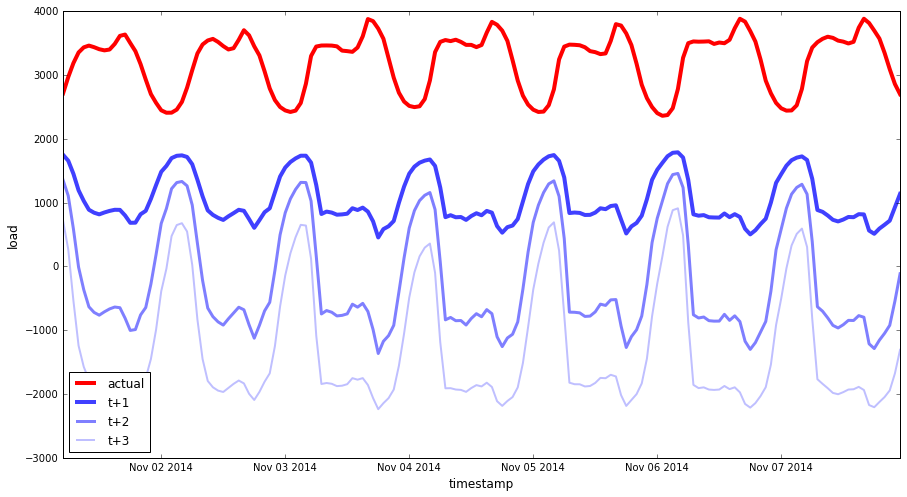

In [27]:
plot_df = eval_df[(eval_df.timestamp<'2014-11-08') & (eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[(eval_df.timestamp<'2014-11-08') & (eval_df.h=='t+'+str(t))]['prediction'].values

fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75)
ax.plot(plot_df['timestamp'], plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5)
ax.plot(plot_df['timestamp'], plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
ax.legend(loc='best')
plt.show()